In [1]:
from __future__ import division
import GetMIT_Map
import os
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
Dep = 'IAH'
Arr = 'BOS'
Year = 2013
print(Dep,'-->',Arr)

('IAH', '-->', 'BOS')


### Convert MIT geometries

In [3]:
MIT_Enroute_geo = GetMIT_Map.ProcessMITData()
pickle.dump(MIT_Enroute_geo,open(os.getcwd() + '/TMI/MIT_WithGeometry_Enroute.p', 'w'))

### Map with MIT

In [3]:
# Map with nominal routes, with replaced departure time

# MIT_Enroute_geo = pickle.load(open(os.getcwd() + '/TMI/MIT_WithGeometry_Enroute.p'))
Dep_Arr = GetMIT_Map.MappingMIT(Dep,Arr,2013,MIT_Enroute_geo, Type = 'Nominal')
Mapping_result = Dep_Arr.Main(parameters = {'AIRWAY':[0.25, 1], 'NAS': 0.25})
print(Dep_Arr.Count_Max_MIT())
MNL_Final = Dep_Arr.MergeWithMNL()
MNL_Final.to_csv(os.getcwd() + '/MNL/Final_MNL_' + Dep + Arr + '_2013.csv', index=False)

(0, 3.600120544433594e-05)
(500, 229.9264850616455)
(1000, 550.3969449996948)
(1500, 797.847697019577)
(10, 1942)


In [4]:
MNL_Final.to_csv(os.getcwd() + '/MNL/Final_MNL_' + Dep + Arr + '_2013.csv', index=False)

In [ ]:
# Map with Actual trajectories, merging part is still under development
MIT_Enroute_geo = pickle.load(open(os.getcwd() + '/TMI/MIT_WithGeometry_Enroute.p'))
Dep_Arr = GetMIT_Map.MappingMIT(Dep,Arr,2013,MIT_Enroute_geo, Type = 'Actual')
Mapping_result = Dep_Arr.Main(parameters = {'AIRWAY':[0.25, 1], 'NAS': 0.25})
print(Dep_Arr.Count_Max_MIT(Mapping_result))

## Analyzing MIT results
### Summarize MIT mapping results

============1679 trajectories in total============
============5 nominal trajectories in total============


/Users/lyn/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/lyn/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


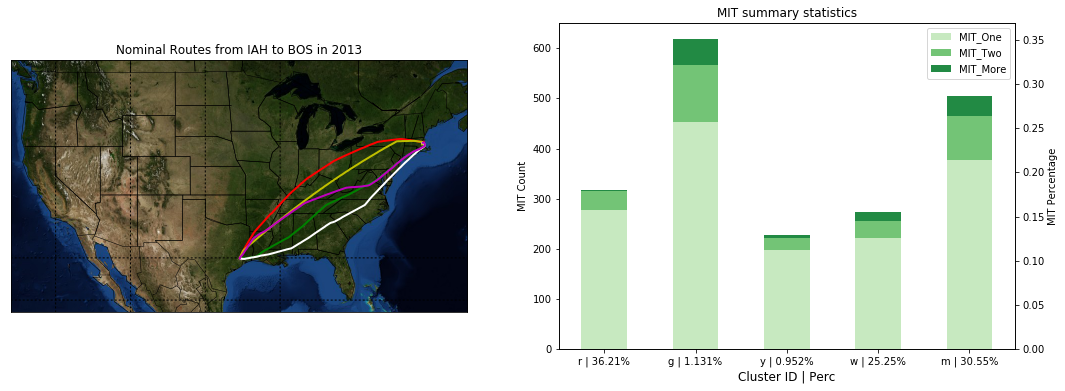

In [4]:
iah_bos = GetMIT_Map.MIT_MappingSummary('IAH','BOS',2013, True)